<a href="https://colab.research.google.com/github/jacobrobertsdev/MLA_JAR/blob/main/MLA2_JAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Machine Learning Assignment #  
**Jacob Roberts**  

## Standard Imports

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [85]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports for specific models
In this section, you will import the models from SKLearn that you will use this in this notebook.

In [86]:
#example - you will replace this with the models you are actually using.
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

## Imports for Splitting Data and Building Pipeline


In [87]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Imports for Performance Measures

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [89]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

# ROC_Curve Function
This function is for plotting the roc_curve

In [90]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])

## Problem 1

### Reading the Data

In [91]:
df = pd.read_csv('/content/gdrive/MyDrive/CS430/Steel_industry_data.csv')
df.columns = ['date', 'usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'C02', 'lag_current_pwr', 'lead_current_pwr', 'nsm', 'week_status', 'day_of_week', 'load_type']
df.head()

,date,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,C02,lag_current_pwr,lead_current_pwr,nsm,week_status,day_of_week,load_type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


### Statistical and Visual Exploration

In [92]:
df.describe()

,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,C02,lag_current_pwr,lead_current_pwr,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


Text(0.5, 1.0, 'Days per Load Type')

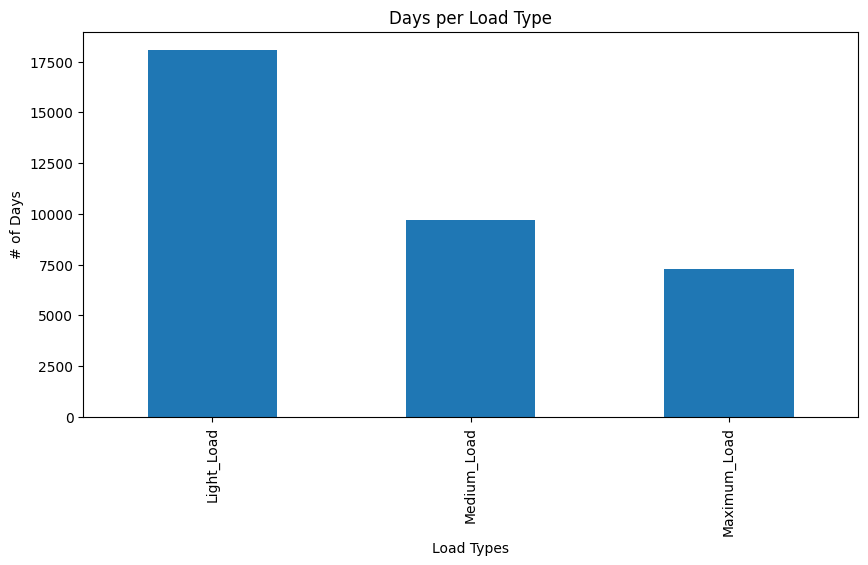

In [93]:
load_type_counts = df['load_type'].value_counts()
bar = load_type_counts.plot(kind='bar', x='load_type', y='count', figsize=(10, 5), legend=False)
load_type_counts.columns = ['load_type', 'count']
bar.set_xlabel("Load Types")
bar.set_ylabel("# of Days")
bar.set_title("Days per Load Type")

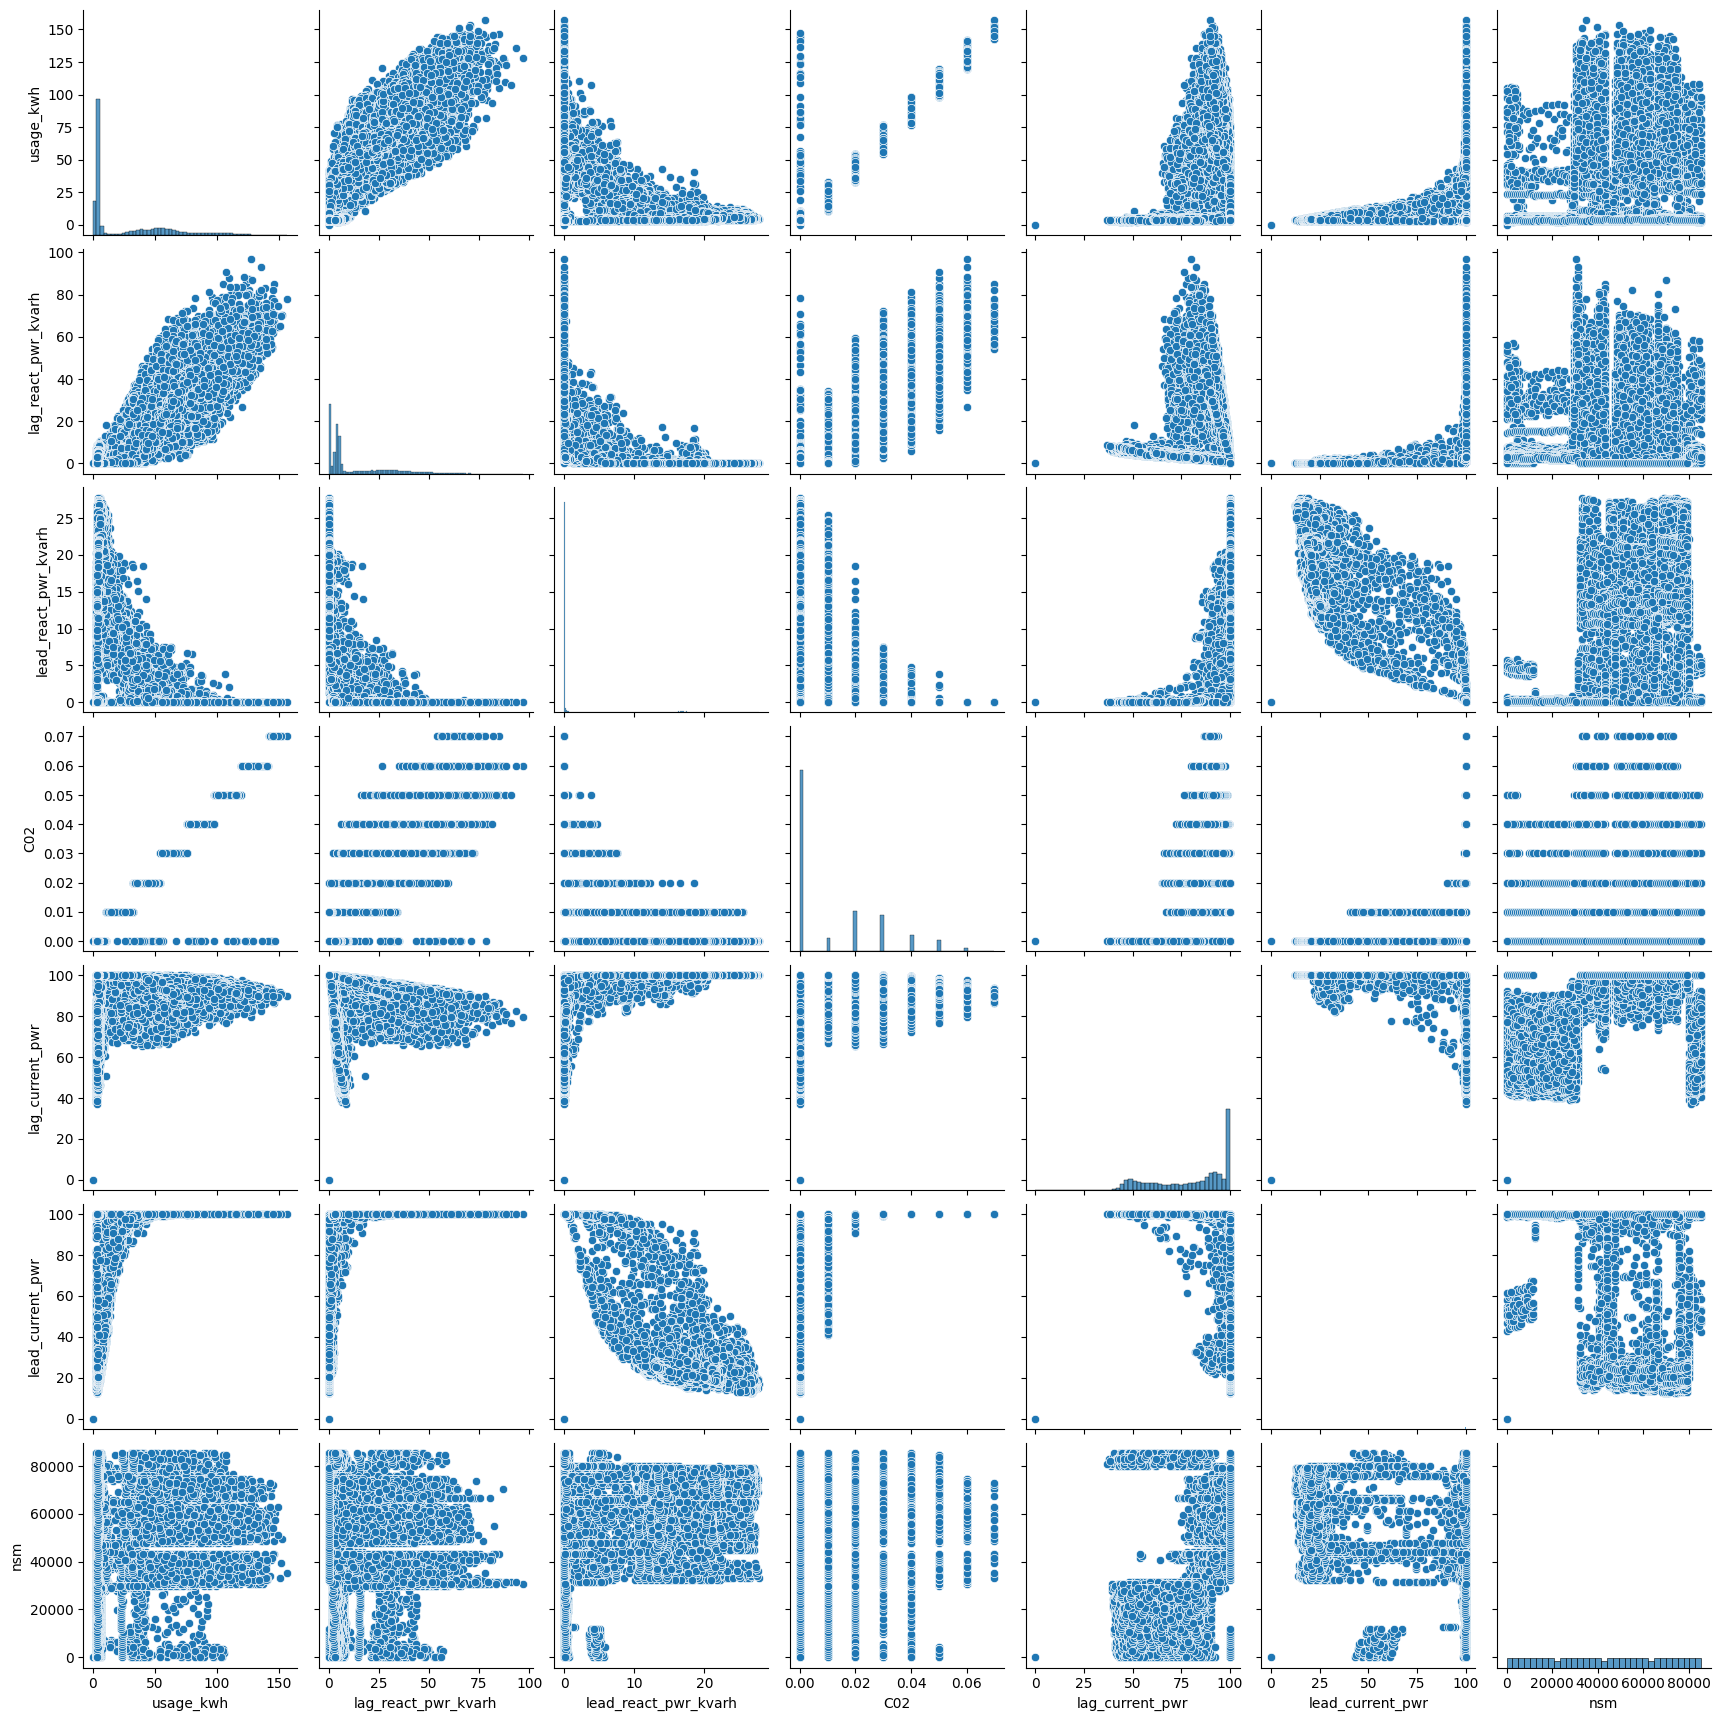

In [94]:
sns.pairplot(df)

#Patterns

Although I don't know what they mean, there are some interesting linear patterns (or seemingly linear) showing in the pair plot for the following relationships.
- usage_kwh and lag_react_pwr_kvarh
- CO2 and *usage_kwh*

### Splitting Data into Train/Test

In [95]:
X = df.drop(columns=['date', 'usage_kwh'])
y = df['usage_kwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

### Building the Pipeline

In [96]:
categories = ['week_status', 'day_of_week', 'load_type']
nums = ['lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'C02', 'lag_current_pwr', 'lead_current_pwr', 'nsm']

col_transform = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categories),
        ('num', MinMaxScaler(), nums)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('transformer', col_transform),
    ('mlr_model', LinearRegression())
])

### Executing the Model

In [97]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['week_status', 'day_of_week',
                                                   'load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'C02', 'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('mlr_model', LinearRegression())])

### Evaluating Model

In [98]:
y_pred = pipeline.predict(X_test)

# RMSE for training set
y_train_pred = pipeline.predict(X_train)
rsme_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# RMSE for test set
rsme_test = np.sqrt(mean_squared_error(y_test, y_pred))

print(rsme_train)
print(rsme_test)

4.580472127397251
5.049417919350001


The RSME for the testing data is higher than that of the training data, so the model seems to be performing worse on unseen data.

In [99]:
# R-squared value for the test set
r2_score(y_test, y_pred)

0.9768635277854335

This score implies that the model is currently doing well at capturing the variation in the data set, on a scale from 0 to 1, 0.97 is a good score.

In [100]:
pipeline.named_steps['mlr_model'].intercept_

-4.554198834371338

In [101]:
pipeline.named_steps['mlr_model'].coef_

array([ 2.89284679e-03, -2.89284679e-03, -1.37889633e-01, -1.13841616e-01,
       -1.24404701e-01,  1.21511854e-01, -1.66436073e-01,  4.53213656e-01,
       -3.21534869e-02, -9.50998238e-01,  2.83976832e-01,  6.67021405e-01,
        2.90610730e+01,  1.97809923e+00,  1.17574454e+02,  6.94709545e+00,
        4.80847435e+00, -2.69095307e-01])

### Conclusion
The model appears to be doing well with relatively consistent RSME's between the training data and testing data. With an R2 score of 0.97, it seems the model would be well suited to predicting the usage_kwh based on the selected features.

## Problem 2

### Reading the Data

In [102]:
df['week_status'] = df['week_status'].replace({'Weekday': 1, 'Weekend': 0})

<ipython-input-102-b979de52ac4b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['week_status'] = df['week_status'].replace({'Weekday': 1, 'Weekend': 0})


### Splitting Data into Train/Test

In [107]:
X2 = df.drop(columns=['date', 'week_status', 'day_of_week'])
y2 = df['week_status']
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=.2, random_state=0)

### Building the Pipeline

In [108]:
categories2 = ['load_type']
nums2 = ['usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'C02', 'lag_current_pwr', 'lead_current_pwr', 'nsm']

col_transform2 = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categories2),
        ('num', MinMaxScaler(), nums2)
    ],
    remainder='passthrough'
)

pipeline2 = Pipeline(steps=[
    ('transformer', col_transform2),
    ('lr_model', LogisticRegression(max_iter=1000))
])

### Executing the Model

In [109]:
pipeline2.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['usage_kwh',
                                                   'lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'C02', 'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('lr_model', LogisticRegression(max_iter=1000))])

### Evaluating Model

In [112]:
y_pred2 = pipeline2.predict(X_test)

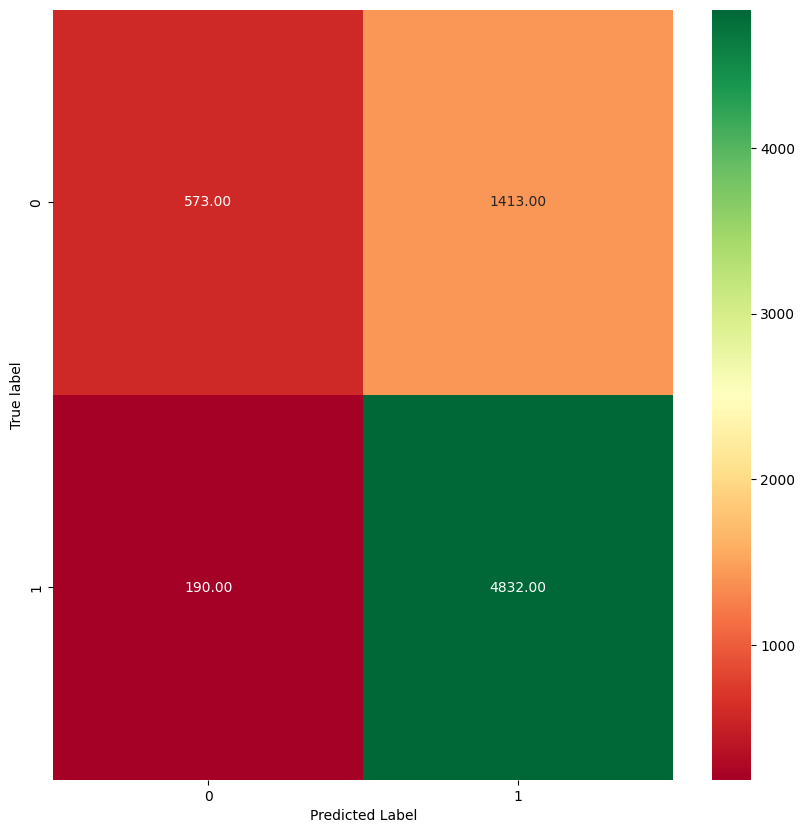

In [113]:
plot_cm(y_test, y_pred2)

In [116]:
print(precision_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))
print(f1_score(y_test, y_pred2))

0.7737389911929544
0.9621664675428117
0.8577261027780243


The model did well identifying positives (.96) out of the total, but did run into some false-positives with a precision score of .77. F1 being .85 means this model did fairly well, but there could be room for improvement, especially considering there are many more positives than negatives in the data.

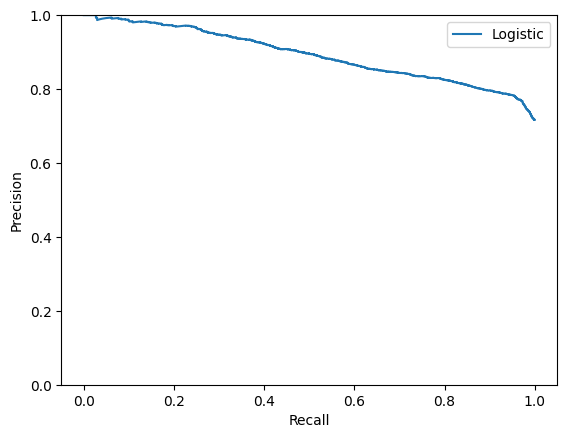

In [126]:
y_pred_proba = pipeline2.predict_proba(X_test)[:,1]
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(lr_recall, lr_precision, label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim(0, 1)
plt.legend()

In [123]:
auc(lr_recall, lr_precision)

0.8928425271566964

I chose a precision-recall plot because the data has a class imbalance (25056 positives and 9984 negatives). The curve shows that as recall increases, precision decreases. The AUC of .89, which is close to the F1 score of .85, implies the model is doing well at distinguishing between positives and negatives.

### Conclusion
Based on the decent precision (.77), excellent recall (.96), decent F1 (.85), and relatively high AUC (.89), it appears the model is doing well but could be improved. Maybe adding some more relevant features could improve the performance, or using a more balanced data set that includes more weekends.